In [2]:
! pip install torchmetrics

In [3]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy

import torch
from torch import nn

import numpy as np

# 1. Create a dataset

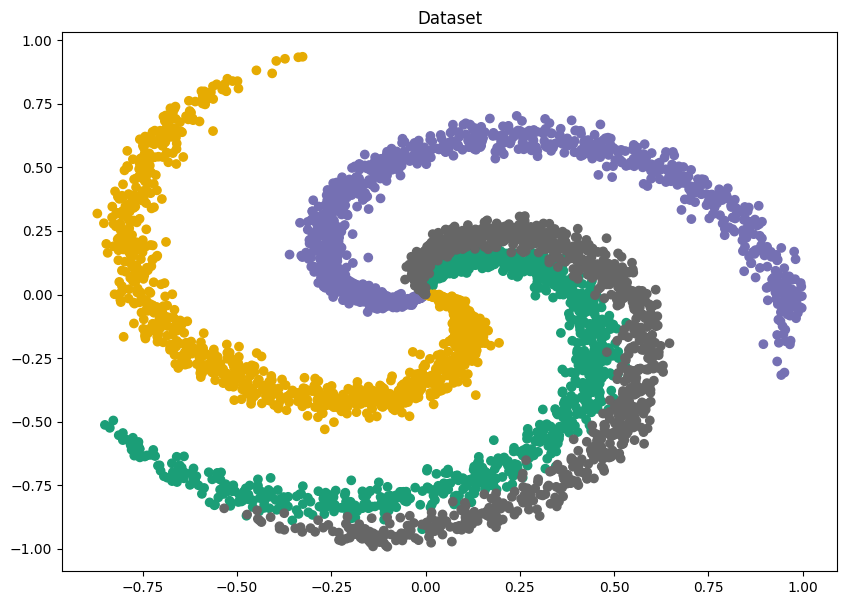

In [4]:
N = 1000 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes

X_np = np.zeros((N*K,D)) # data matrix (each row = single example)
y_np = np.zeros(N*K, dtype='uint8') # class labels

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.15 # theta
  X_np[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y_np[ix] = j
  
# lets visualize the data:
plt.figure(figsize=(10, 7))
plt.scatter(X_np[:,0], X_np[:,1], c=y_np, marker='o', cmap=plt.cm.Dark2)
plt.title("Dataset")
plt.show()

# 2. Convert the numpy data to PyTorch tensors

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_t = torch.from_numpy(X_np).to(device=device, dtype=torch.float32)
y_t = torch.from_numpy(y_np).to(device=device, dtype=torch.float32)

X_t.shape, y_t.shape 

(torch.Size([4000, 2]), torch.Size([4000]))

# 3. Create a train, val, test set

In [6]:
N = X_t.shape[0]

g = torch.Generator(device=device).manual_seed(42)
indices = torch.randperm(N, generator=g, device=device)

ratios = [0.7, 0.2, 0.1]
train, val, _ = (int(x * N) for x in ratios)

train_indices = indices[:train]
val_indices = indices[train:train+val]
test_indices = indices[train+val:]

X_train, y_train = X_t[train_indices], y_t[train_indices]
X_val, y_val = X_t[val_indices], y_t[val_indices]
X_test, y_test = X_t[test_indices], y_t[test_indices]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

y_train.dtype

torch.float32

# 4. Define a model

In [7]:
class SpiralDataset(nn.Module):
    def __init__(self, in_features, out_features, hiddlen_layers=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hiddlen_layers),
            nn.ReLU(),
            nn.Linear(hiddlen_layers, hiddlen_layers),
            nn.ReLU(),
            nn.Linear(hiddlen_layers, hiddlen_layers),
            nn.ReLU(),
            nn.Linear(hiddlen_layers, out_features)
        )
    def forward(self, x):
        return self.net(x)     

# 5. Create loss metrics function

In [8]:
from torchmetrics.classification import MulticlassAccuracy

# def get_loss_metrics(y_logits, y_train):
#     acc_metrics = MulticlassAccuracy(num_classes=n_classes).to(device=device)
#     batch_acc = acc_metrics(y_logits, y_train)
#     return batch_acc

def get_loss_metrics(y_logits, y_train):
    y_ = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_, dim=1).float()
    acc = y_preds.view_as(y_train).eq(y_train).float().mean()
    return acc

# 6. Create a training loop

In [9]:
def train_one_epoch(model, optimizer, loss_fn, X_train, y_train):
    model.train()
    optimizer.zero_grad(set_to_none=True)
    
    y_logits = model(X_train)
    loss = loss_fn(y_logits, y_train.long())
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        acc = get_loss_metrics(y_logits, y_train)
    return loss.item(), acc.item() * 100

def validate_one_epoch(model, loss_fn, X_val, y_val):
    model.eval()
    
    with torch.inference_mode():
        y_logits = model(X_val)
        loss = loss_fn(y_logits, y_val.long())
        
        acc = get_loss_metrics(y_logits, y_val)
        
        return loss.item(), acc.item() * 100
    
def fit(model, optimizer, loss_fn, X_train, y_train, X_val, y_val, epochs=50, verbose_every=5):
    history = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [] }
    
    for ep in range(1, epochs+1):
        train_loss, train_acc = train_one_epoch(model, optimizer, loss_fn, X_train, y_train)
        val_loss, val_acc = validate_one_epoch(model, loss_fn, X_val, y_val)
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        if ep % verbose_every == 0 or ep == 0 or ep == epochs:
            print(f"Epoch: {ep:3d} |"
                  f"Training loss: {train_loss:.4f}, Training Accuracy: {train_acc:6.2f} |"
                  f"Validation loss: {val_loss:.4f}, Validation Accuracy: {val_acc:6.2f}")
    return history        

# 7. Create model instance, define a loss function and optimizer

In [10]:
n_classes = 4
model = SpiralDataset(in_features=2, out_features=4, hiddlen_layers=128).to(device=device)
model.state_dict()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 8. Fit the data

In [11]:
hist = fit(model, optimizer, loss_fn, X_train, y_train, X_val, y_val, epochs=300)

Epoch:   5 |Training loss: 1.3395, Training Accuracy:  44.71 |Validation loss: 1.3247, Validation Accuracy:  46.88
Epoch:  10 |Training loss: 1.2775, Training Accuracy:  45.18 |Validation loss: 1.2543, Validation Accuracy:  46.75
Epoch:  15 |Training loss: 1.1959, Training Accuracy:  44.18 |Validation loss: 1.1623, Validation Accuracy:  46.38
Epoch:  20 |Training loss: 1.1011, Training Accuracy:  44.04 |Validation loss: 1.0596, Validation Accuracy:  46.75
Epoch:  25 |Training loss: 1.0154, Training Accuracy:  45.07 |Validation loss: 0.9727, Validation Accuracy:  46.75
Epoch:  30 |Training loss: 0.9534, Training Accuracy:  46.18 |Validation loss: 0.9081, Validation Accuracy:  48.88
Epoch:  35 |Training loss: 0.9016, Training Accuracy:  48.21 |Validation loss: 0.8539, Validation Accuracy:  51.13
Epoch:  40 |Training loss: 0.8455, Training Accuracy:  52.36 |Validation loss: 0.7975, Validation Accuracy:  55.37
Epoch:  45 |Training loss: 0.7820, Training Accuracy:  57.39 |Validation loss: 0

# 9. Plot train loss, acc and validation loss, acc

In [12]:
def plot_history(history, every=1):
    epochs = np.arange(1, len(history["train_loss"]) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    
    # -- Training & Validation losses --
    ax = axes[0]
    ax.plot(epochs[::every], history["train_loss"][::every], label="Training loss")
    ax.plot(epochs[::every], history["val_loss"][::every], label="Validation loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Losses")
    ax.set_title("Losses vs. Epoch")
    ax.grid(True)
    ax.legend()

    # -- Training and validation accuracy --
    ax = axes[1]
    ax.plot(epochs[::every], history["train_acc"][::every], label="Training Accuracy")
    ax.plot(epochs[::every], history["val_acc"][::every], label="Validation Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy vs. Epochs")
    ax.grid(True)
    ax.legend()
    
    plt.show()    

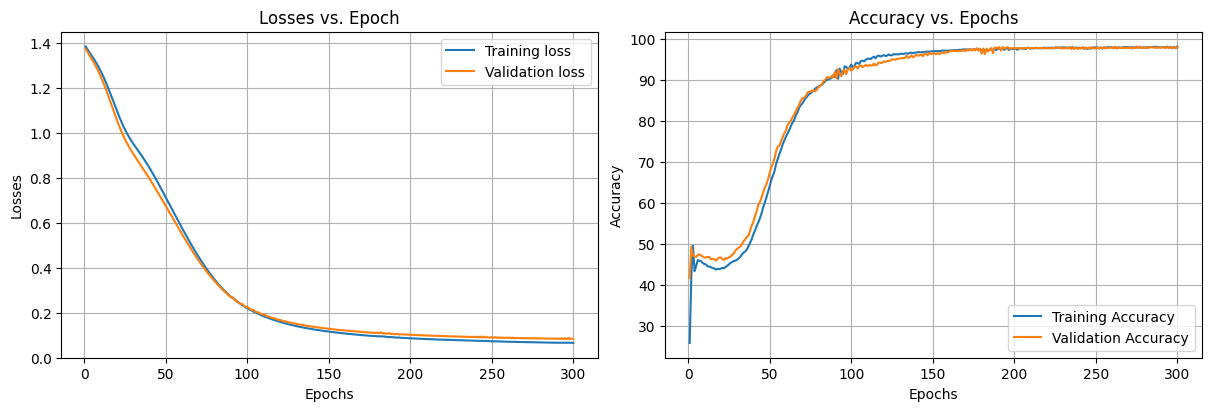

In [13]:
plot_history(hist)

# 10. Draw a decision boundry  

In [14]:
def plot_multiclass_boundary(model, X_np, y_np, h=0.0025):
    pad = 0.5
    x_min, x_max = X_np[:,0].min()-pad, X_np[:,0].max()+pad
    y_min, y_max = X_np[:,1].min()-pad, X_np[:,1].max()+pad

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    print(f"xx.shape: {xx.shape}")
    print(f"yy.shape: {yy.shape}")
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.from_numpy(grid).float().to(next(model.parameters()).device)
    print(f"grid_t.shape: {grid_t.shape}")

    model.eval()
    with torch.inference_mode():
        logits = model(grid_t)                   # [Ngrid, C]
        print(f"logits.shape: {logits.shape}")
        preds  = torch.argmax(logits, dim=1)     # class ids
        print(f"preds.shape: {preds.shape}")
        Z = preds.view(xx.shape).cpu().numpy()
        print(f"Z.shape: {Z.shape}")

    plt.figure(figsize=(10,7))
    # Background regions by class
    plt.contourf(xx, yy, Z, levels=25, alpha=0.25, cmap=plt.cm.Dark2)

    # Boundary lines at half-integers between class ids (0|1, 1|2, 2|3, ...)
    print(f"Z.max() : {Z.max()}")
    num_classes = int(Z.max() + 1)
    levels = np.arange(num_classes)
    print(f"levels: {levels}")
    plt.contour(xx, yy, Z, levels=levels, colors='k')

    # Training points
    plt.scatter(X_np[:,0], X_np[:,1], c=y_np, cmap=plt.cm.Dark2)
    plt.title("Multiclass decision boundaries")
    plt.xlabel("x1"); plt.ylabel("x2")
    # plt.gca().set_aspect('equal', 'box')
    plt.show()

xx.shape: (1171, 1148)
yy.shape: (1171, 1148)
grid_t.shape: torch.Size([1344308, 2])
logits.shape: torch.Size([1344308, 4])
preds.shape: torch.Size([1344308])
Z.shape: (1171, 1148)
Z.max() : 3
levels: [0 1 2 3]


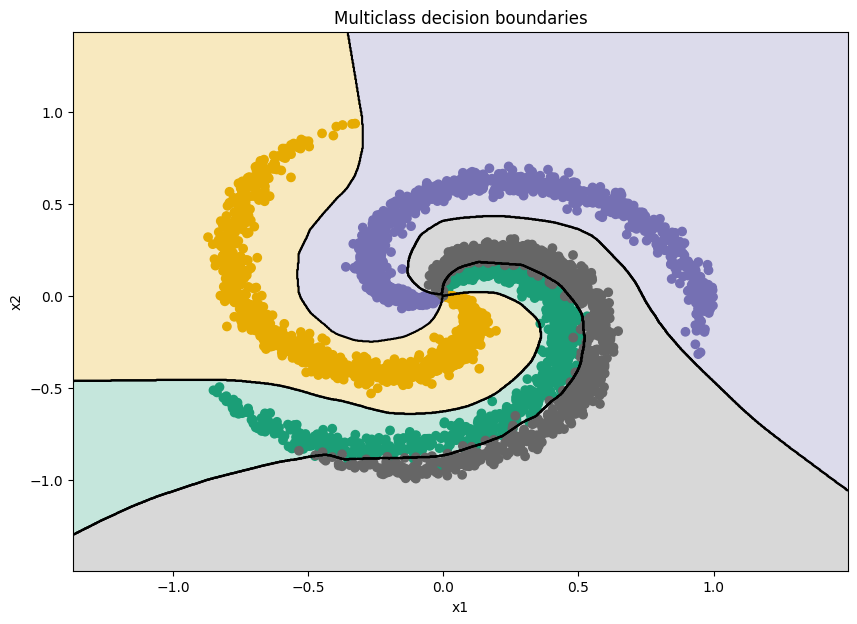

In [15]:
plot_multiclass_boundary(model, X_np, y_np)


# 11. Test the data on the testset  




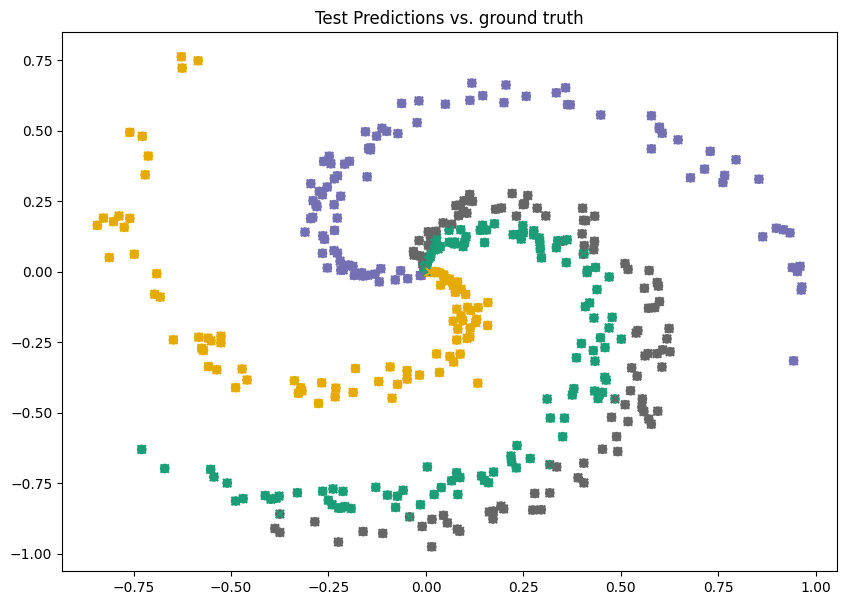

In [16]:
model.eval()
with torch.inference_mode():
    logits = model(X_test)
    p_ = torch.softmax(logits, dim=1)
    preds = torch.argmax(p_, dim=1)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), c=y_test.cpu().numpy(), marker='o', cmap=plt.cm.Dark2)
    plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), c=preds.cpu().numpy(), marker='x', cmap=plt.cm.Dark2)
    
    plt.title("Test Predictions vs. ground truth")
    plt.show()
    